# 2회차 Part 2 범위
1. [다차원척도법MDS-계량적(구간/비율)](#계량적MDS)
2. [다차원척도법-비계량적(순서척도)](#비계량적MDS)
3. [대응분석](#대응분석)
4. [시계열분석-fbprophet](#시계열분석)
5. [연관성분석-장바구니분석](#연관성분석)

reference
1. Step by Step 파이썬 비즈니스 통계분석 / 김형수
2. [H2O-500ml 깃허브](https://github.com/H2O-500ml/ADP)
3. [prince 패키지 활용문서](https://github.com/MaxHalford/prince#multiple-correspondence-analysis-mca)
4. [prophet 패키지 공식문서](https://facebook.github.io/prophet/docs/quick_start.html)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 계량적MDS
- 변수의 중요도를 기준으로 **좌표평면에 데이터를 매핑**하여 비교

- 숫자로 표현할 수 있는 양적자료에 사용
  - 구간척도: 연속적인 수로 수량화 가능, 숫자 간 간격 동일, 절대적인 0 존재X
  ex) 온도, 만족도조사, 선호도조사 
  - 비율척도: 연속적인 수로 수량화 가능, 절대적인 0 존재O
  ex) 몸무게, 매출액, 방문빈도

In [3]:
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/data/adp/MDS1.csv', sep = ',', encoding = 'CP949')
df.head()

,shop,이미지,접근성,서비스,친절성,편의시설,인지도,가격만족도
0,A쇼핑,3.4,4.1,8.1,7.8,6.4,7.8,7.7
1,B쇼핑,4.7,2.8,7.6,6.2,5.4,8.9,6.8
2,C쇼핑,8.1,3.1,7.5,2.4,2.6,5.5,6.7
3,D쇼핑,7.9,7.5,2.3,3.8,8.4,1.6,7.8
4,E쇼핑,4.2,2.6,4.9,7.0,2.7,8.5,5.8


In [4]:
## data의 속성값 거리행렬을 계산하고 이를 기반으로  n차원의 좌표값을 생성
clf = MDS(n_components=2, random_state = 123).fit(df.loc[:,'이미지':'가격만족도']) ##MDS 모형 생성
X_mds = clf.fit_transform(df.loc[:, '이미지':'가격만족도']) # 모형에 data를 적합하고 생성된 좌표를 저장
X_mds

array([[-5.12747416, -0.46862067],
       [-3.25268823,  1.50430496],
       [ 3.52362088,  2.80304347],
       [ 2.97433754, -7.052197  ],
       [-3.84248425,  4.10485347],
       [ 4.66327843, -5.74998855],
       [ 1.06140978,  4.85860431]])

In [5]:
## 좌표 시각화하기
import matplotlib
import matplotlib.pyplot as plt

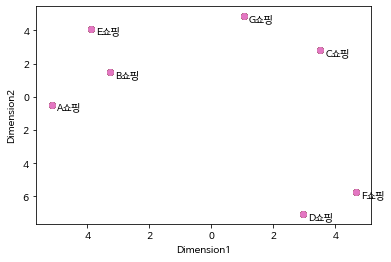

In [6]:
## Colab으로 작업해서 한글이 깨집니다ㅠㅠ jupyter로 하실 땐 rcParams 'font family' 변경해주시고 돌리면 됩니다.
labels = df.shop
for label, x_count, y_count in zip(labels, X_mds[:, 0], X_mds[:, 1]):
  plt.annotate(label, 
               xycoords = 'data',
               textcoords = 'offset points',
               xy = (x_count, y_count), 
               xytext = (5,-5))
  plt.xlabel('Dimension1')
  plt.ylabel('Dimension2')
  plt.scatter(X_mds[:,0], X_mds[:, 1])

결과 해석하기
- 비슷한 위치에 놓여있는 좌표들은 속성값이 비슷하다는 이야기이므로 경쟁관계에 놓여있다고 말할 수 있다.
- 위 예시에서는 쇼핑몰 A, B, E가 직접적인 경쟁관계에 있고, G와 C가, D와 F가 경쟁관계에 있다.

### 속성 - 경쟁구조 분석
- 데이터의 거리행렬을 기준으로 n차원 매핑하면 비슷한 특성을 가진 경쟁관계를 파악할 수 있지만, 어떤 속성이 해당 데이터들을 가깝게 놓이도록 했는지 알기 어려움
- 속성-경쟁관계 파악을 위해 속성을 기존 포지셔닝맵에 매핑하는 방법을 활용

In [7]:
import statsmodels.formula.api as sm

df1 = df.loc[:, '이미지':'가격만족도']
df1 = (df1 - df1.min()) / (df1.max() - df1.min()) ## Min-max Normalization (여기서는 자극값~차원1+차원2 .. 의 회귀식을 위해 정규화한 듯?)
## 자극값을 0~1 사이로 만들어서 독립변수와 scale을 맞춰주려고 했나봄 자세한건 함께 토의(p.302)
clf = MDS(n_components = 2, random_state = 123).fit(df1)
X_mds = clf.fit_transform(df1)

df1['차원1'] = X_mds[:,0]
df1['차원2'] = X_mds[:,1]
model = []
model.append(sm.ols(formula = '이미지~차원1+차원2', data = df1).fit())
model.append(sm.ols(formula = '접근성~차원1+차원2', data = df1).fit())
model.append(sm.ols(formula = '서비스~차원1+차원2', data = df1).fit())
model.append(sm.ols(formula = '친절성~차원1+차원2', data = df1).fit())
model.append(sm.ols(formula = '편의시설~차원1+차원2', data = df1).fit())
model.append(sm.ols(formula = '인지도~차원1+차원2', data = df1).fit())
model.append(sm.ols(formula = '가격만족도~차원1+차원2', data = df1).fit())
속성 = []
for i in range(0,7,1):
  속성.append([model[i].params[1], model[i].params[2]]) ## 각 회귀식의 속성1, 속성2 coefficients를 가져옴 ->이게 속성들의 차원1, 2 좌표가 됨
속성 = np.array(속성)
자극점및속성 = np.hstack([X_mds, 속성])
자극점및속성

array([[-1.03202434, -0.00641877,  0.54559765, -0.10043696],
       [-0.53757021,  0.28266513,  0.12883623, -0.42074909],
       [ 0.71120717,  0.32238053, -0.06935846,  0.37280673],
       [ 0.19723554, -1.25906064, -0.61440613,  0.00507243],
       [-0.51913327,  0.83498409, -0.1219796 , -0.48451721],
       [ 0.69997592, -0.99534218, -0.17062737,  0.41435935],
       [ 0.4803092 ,  0.82079184, -0.29692794, -0.32744816]])

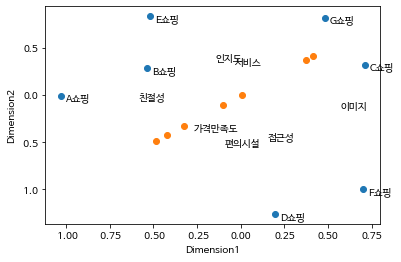

In [8]:
## 그래프로 시각화
labels = df.shop
for label, x_count, y_count in zip(labels, 자극점및속성[:,0], 자극점및속성[:,1]):
  plt.annotate(label,
               xycoords = 'data',
               textcoords = 'offset points',
               xy = (x_count, y_count),
               xytext = (5,-5))
labels2 = df1.columns
for label, x_count, y_count in zip(labels2, 자극점및속성[:,2], 자극점및속성[:,3]):
  plt.annotate(label,
               xycoords = 'data',
               textcoords = 'offset points',
               xy = (x_count, y_count),
               xytext = (5,-5))
plt.xlabel('Dimension1')
plt.ylabel('Dimension2')
plt.scatter(자극점및속성[:,0], 자극점및속성[:,1])
plt.scatter(자극점및속성[:,3], 자극점및속성[:,3])

결과해석
- 각 자극점은 자기 위치에서 가까운 속성값에 강점이 있음
- 각 자극점은 자기 위치와 먼 속성값은 약점이라고 할 수 있음

## 비계량적MDS (상응분석 Correspondence Analysis)
- 빈도교차표의 행과 열(빈도자료)을 자극점으로 표시함
- 빈도 데이터의 카이제곱 값을 계산해 n차원의 좌표값을 만들어냄
- 숫자로 표현할 수 없는 질적자료에 사용
  - 명목척도: 이름만 나타내는 척도로 숫자는 '정도'의 의미가 없고 카테고리만 표현
    ex) 색깔, 성별, 취미
  - 순위/서열척도: 숫자는 서열을 나타내지만 '정도'의 의미가 없음
    ex) 학년, 만족도
- 활용하는 변수의 개수에 따라 단순 상응분석(2개)과 다중 상응분석(3개 이상)으로 나뉨
  - 단순 상응분석: 빈도교차표 내에서 하나의 관측치가 하나의 셀에만 속한 경우
  - 다중 상응분석: 빈도교차표 내에서 하나의 관측치가 최소 2개 이상의 셀 빈도에 영향을 미치는 경우 (복수 응답으로 이루어진 설문지의 빈도교차표는 이와 같은 형태를 띠게 됨)

### 단순상응분석
prince 패키지는 ADP에서 제공되지 않지만, 카이제곱값을 구하고 sklearn.manifold의 MDS 패키지를 그대로 사용하는 것도 가능하기 때문에 해당 방법으로 대비해야 할 듯

In [9]:
import pandas as pd
import prince
df_cor = pd.read_csv('/content/drive/MyDrive/data/adp/Correspondence.csv', sep = ',', encoding = 'CP949')
df_cor.head()

,id,resort,slope,traffic,lodging,etc
0,1,대명,Slope-H,Traffic-H,Lodging-H,Etc-H
1,2,대명,Slope-H,Traffic-M,Lodging-H,Etc-L
2,3,대명,Slope-L,Traffic-M,Lodging-M,Etc-M
3,4,대명,Slope-L,Traffic-H,Lodging-M,Etc-M
4,5,대명,Slope-M,Traffic-M,Lodging-L,Etc-M


In [10]:
## 빈도교차표 만들기
X = pd.crosstab(df_cor.resort, df_cor.slope, margins = False) 
X

slope,Slope-H,Slope-L,Slope-M
resort,,,
대명,3,5,2
리솜,3,4,3
무주,2,6,2
용평,4,1,5
한화,5,2,3


In [11]:
## 차원좌표값 계산하기
ca = prince.CA(n_components = 2).fit(X)
print('리조트 기준 차원좌표\n', ca.row_coordinates(X))
print('\n슬로프 기준 차원좌표\n', ca.column_coordinates(X))

리조트 기준 차원좌표
            0         1
대명 -0.297192  0.064504
리솜 -0.079668 -0.052946
무주 -0.496362 -0.067862
용평  0.554549 -0.155482
한화  0.318672  0.211785

슬로프 기준 차원좌표
                 0         1
Slope-H  0.256394  0.155651
Slope-L -0.515052 -0.012403
Slope-M  0.327482 -0.161521


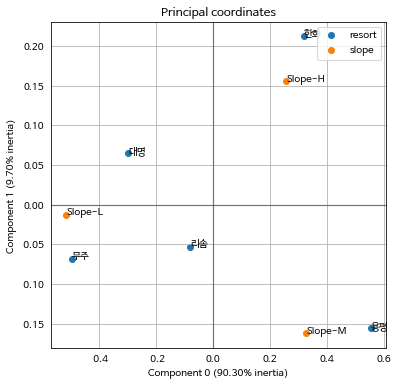

In [12]:
## 좌표에 시각화하기
ca.plot_coordinates(X=X) #X에는 빈도교차표 데이터를 넣는다
plt.show()

결과해석
- 기본적으로 계량적 MDS와 동일하게 해석하면 된다
- 한화는 Slope-H와 가까우므로 높은 난이도의 슬로프를 가지고 있고, 용평은 중간 난이도의 슬로프, 대명/무주/리솜은 상대적으로 낮은 수준의 슬로프를 가지고 있으며 이들 세 리조트가 경쟁관계라고 말할 수 있음

### 다중상응분석

In [13]:
X = df_cor[['resort', 'slope', 'traffic', 'lodging', 'etc']]
mca = prince.MCA(n_components = 2) ## 책처럼 바로 mca().fit(X)로 코딩하면 fit이 정의 안됐다고 오류뜸
mca = mca.fit(X)
print('\n각 변수별 차원좌표\n', mca.column_coordinates(X))


각 변수별 차원좌표
                           0         1
resort_대명         -0.478198 -0.732122
resort_리솜          1.340944 -0.427030
resort_무주          0.192214  1.728775
resort_용평         -0.978080 -0.366669
resort_한화         -0.076880 -0.202954
slope_Slope-H      0.404687 -0.382117
slope_Slope-L      0.086027  0.427853
slope_Slope-M     -0.561878 -0.080357
traffic_Traffic-H -0.597015 -0.824843
traffic_Traffic-L  0.914458  0.511569
traffic_Traffic-M -0.297904  0.058322
lodging_Lodging-H  0.614713 -0.865625
lodging_Lodging-L -0.615669  0.668687
lodging_Lodging-M -0.067505  0.260296
etc_Etc-H          1.070717 -0.049837
etc_Etc-L         -0.553935 -0.265351
etc_Etc-M         -0.318144  0.222761


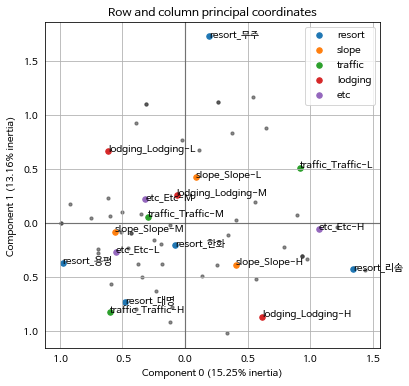

In [14]:
## 그래프로 시각화하기
mca.plot_coordinates(X=X, show_column_labels = True)

결과해석
- 가까운 점들을 통해 경쟁관계에 놓인 데이터들을 알 수 있음
- 경쟁관계에서도 상대적으로 가깝게 놓인 속성값을 통해 자사가 비교우위를 가지고 있는 강점을 파악할 수 있음
- 비교우위를 극대화할지, 경쟁관계에 놓여있는 특성을 보완할지 이부분은 자율적으로 판단하면 됨
- X축과 Y축에 쓰인 component 1과 component 0의 %는 전체 카이제곱값에서 해당 차원값이 차지하고 있는 비율임
- 이 예시에서는 두 차원이 설명하는 카이제곱이 약 30%로, 전체 데이터 정보의 30%만을 활용하고 있다는 소리임. 차원을 축소하는 과정에서 70%의 정보가 유실됨

## 대응분석
- 대응분석(Correspondence Analysis) = 카이제곱검정 = 범주형자료의 독립성검정
- 도수분포표의 기대도수와 실제로 나타난 도수를 비교해 변수 간 연관성이 있는지 파악함
- 각 셀의 기댓값 = (행빈도합 X 열빈도합) / 총 빈도합
- 각 셀의 카이제곱값 =  (관측값 - 기댓값)^2 / 기댓값 

In [15]:
from scipy import stats
df_ca = pd.read_csv('/content/drive/MyDrive/data/adp/Ashopping.csv', encoding = 'CP949')
df_ca.head()

,고객ID,이탈여부,총_매출액,방문빈도,1회_평균매출액,할인권_사용 횟수,총_할인_금액,고객등급,구매유형,클레임접수여부,구매_카테고리_수,거주지역,성별,고객_나이대,거래기간,할인민감여부,멤버쉽_프로그램_가입전_만족도,멤버쉽_프로그램_가입후_만족도,Recency,Frequency,Monetary,상품_만족도,매장_만족도,서비스_만족도,상품_품질,상품_다양성,가격_적절성,상품_진열_위치,상품_설명_표시,매장_청결성,공간_편의성,시야_확보성,음향_적절성,안내_표지판_설명,친절성,신속성,책임성,정확성,전문성
0,1,0,4007080,17,235711,1,5445,1,4,0,6,6,1,4,1079,0,5,7,7,3,4,6,5,6,7,7,6,7.0,6.0,6,7,6,6,6,6,6,6,6,6
1,2,1,3168400,14,226314,22,350995,2,4,0,4,4,1,1,537,0,2,3,2,3,3,2,5,4,6,7,6,6.0,NaN,7,7,6,6,6,5,3,6,6,6
2,3,0,2680780,18,148932,6,186045,1,4,1,6,6,1,6,1080,0,6,6,7,3,2,4,6,7,6,7,6,7.0,NaN,6,6,6,6,6,7,7,6,6,7
3,4,0,5946600,17,349800,1,5195,1,4,1,5,5,1,6,1019,0,3,5,7,3,5,3,5,5,6,6,6,5.0,6.0,6,6,5,6,6,6,6,6,5,6
4,5,0,13745950,73,188301,9,246350,1,2,0,6,6,0,6,1086,0,5,6,7,6,7,5,6,6,5,6,6,5.0,6.0,5,6,6,6,5,5,6,6,5,6


In [16]:
X = pd.crosstab(df_ca.성별, df_ca.클레임접수여부, margins = False)
X

클레임접수여부,0,1
성별,,
0,139,10
1,402,449


In [17]:
stats.chi2_contingency(X) ##순서대로 chi2통계량, p-value, 자유도, 각 셀의 기대도수

(106.43790651350751, 5.911607287197053e-25, 1, array([[ 80.609,  68.391],
        [460.391, 390.609]]))

결과해석
- 유의확률은 0.01 이하로 유의수준 0.01에서 귀무가설을 기각하고 A 쇼핑몰 고객들의 성별과 클레임 접수여부가 연관성이 있다고 결론
- 성별 1에 해당하는 사람들은 기대도수보다 클레임을 더 많이 걸었기 때문에(실제 449, 기대도수 390) 해당 성별 고객들을 만족시킬 수 있는 방안이 필요

## 시계열분석
ADP 제공 패키지에 포함됨

- fbprophet은 이론 기반인 ARIMA 모형과 다르게 경험적 규칙을 기반으로 미래의 값을 예측하는 회귀모형

In [18]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv"
df_ts = pd.read_csv(url)
df_ts.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [19]:
from fbprophet import Prophet
m = Prophet()
m.fit(df_ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = m.make_future_dataframe(periods=365) ## 1년치의 미래 datetime 생성
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #yhat은 예측값

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.200924,7.500973,8.944483
3266,2017-01-16,8.525932,7.812838,9.234188
3267,2017-01-17,8.313330,7.637176,9.032777
3268,2017-01-18,8.145923,7.424574,8.864730
3269,2017-01-19,8.157831,7.388418,8.877741


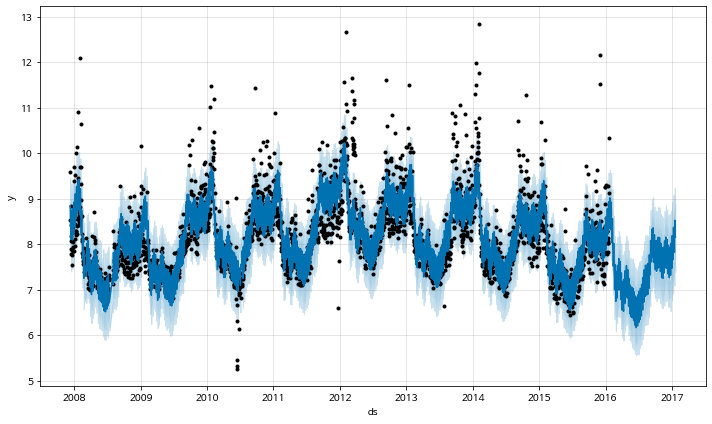

In [22]:
## 예측값 시각화
fig1 = m.plot(forecast)

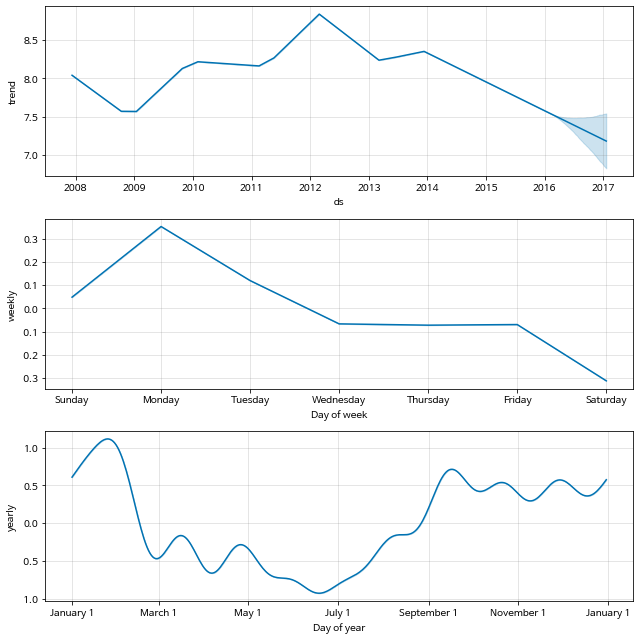

In [23]:
## 연,월,일 단위의 추세 확인
fig2 = m.plot_components(forecast)

## 연관성분석
- 어떤 상품이 함께 팔리는가를 분석함으로써 경향성을 파악
- 연관규칙(if->then)을 통해 **A 제품을 구매하는 사람이 n% 확률로 B제품을 구매**하는지 확인
- 연관성 규칙의 종류
  - 행동 가능한 규칙: 룰의 의미가 이해되고 실행이 바로 가능한 정보
    ex) 물-라면, 기저귀-맥주
  - 사소한 규칙: 이미 다 알고 있는 규칙으로 활용 관점은 낮지만 신뢰성 재확인 가능
    ex) 삼겹살-상추
  - 설명 불가능한 규칙: 설명되지 않고 실제 행동을 취할 수 없는 규칙
    ex) 허리케인->딸기맛사탕

In [24]:
import warnings
warnings.warn('once')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df_lotto = pd.read_csv('/content/drive/MyDrive/data/ADP/202109스터디/20210710/lotto.csv')
df_lotto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   time_id  859 non-null    int64
 1   num1     859 non-null    int64
 2   num2     859 non-null    int64
 3   num3     859 non-null    int64
 4   num4     859 non-null    int64
 5   num5     859 non-null    int64
 6   num6     859 non-null    int64
dtypes: int64(7)
memory usage: 47.1 KB


In [26]:
df_lotto.head()

,time_id,num1,num2,num3,num4,num5,num6
0,859,8,22,35,38,39,41
1,858,9,13,32,38,39,43
2,857,6,10,16,28,34,38
3,856,10,24,40,41,43,44
4,855,8,15,17,19,43,44


### Transaction 데이터로 변환하기
1) melt를 사용하는 방법 (ADP 제공 패키지에 없음)

In [27]:
## transaction data로 변환 후 가장 많이 등장한 상위 10개 번호를 막대그래프로 뽑아내고 이에 대해 설명
melt = pd.melt(df_lotto, id_vars = ['time_id'])
melt.head()

,time_id,variable,value
0,859,num1,8
1,858,num1,9
2,857,num1,6
3,856,num1,10
4,855,num1,8


In [28]:
pivot = melt.groupby('value')[['variable']].count().sort_values(by='variable', ascending = False)[:10].reset_index() #groupby시 variable에 count 값이 들어가고 index는 value인 pivot table
pivot.head()

,value,variable
0,34,134
1,40,126
2,27,126
3,43,125
4,20,124


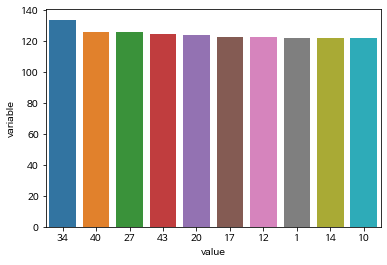

In [29]:
sns.barplot(x = 'value', y = 'variable', data= pivot, order = pivot['value'])
plt.show()

2) mlxtend를 사용하는 법(ADP 제공 패키지에 존재)

http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/

In [30]:
from mlxtend.preprocessing import TransactionEncoder
## mlxtend는 list 속 list형식의 데이터를 One-hot encoding된 numpy array로 변환
list_lotto = df_lotto[df_lotto.columns[1:]].values.tolist() ## num1~num5 column의 value가 row마다 list형식으로 출력, 2d array를 tolist()로 리스트변환
te = TransactionEncoder()
te_ary = te.fit(list_lotto).transform(list_lotto) ##행:구매회차, 열: value(구매물품), 값: Boolean type 인 numpy 2d array
te_lotto = pd.DataFrame(te_ary, columns = te.columns_)

te_lotto.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False,False
2,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,True,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False


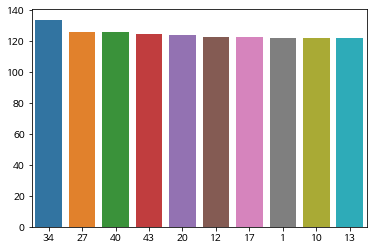

In [31]:
freq_lotto = te_lotto.sum(axis = 0).sort_values(ascending = False) ## axis=0이 column 기준으로 모든 row의 값을 더함, pd.Series로 return
sns.barplot(x = freq_lotto.index[:10].tolist(), y = freq_lotto.values[:10].tolist(), order = freq_lotto.index[:10].tolist())
plt.show()

### 연관규칙(Association Rule) 만들기
- Apriori algorithm이 사용되는 예시
  - 신용카드 사기를 당했을 때 주로 결제되는 내역 패턴
  - 암 발생 시 빈번히 나타나는 DNA 패턴과 단백질 서열 검사
- 빈도 평가 척도
  - 지지도
    - support(X) = n(X) / N
    - support(X,Y) = n(X∩Y) / N
    - 특정 아이템이 발생한 빈도
  - 신뢰도
    - confidence(X→Y) = n(X∩Y) / n(X)
    - 아이템 X를 포함하는 거래 중 아이템 Y도 거래하는 비율
  - 향상도
    - lift(X→Y) = confidence(X→Y) / support(Y)
    - Y 구매가 이루어진 확률 대비 X를 샀을 때 Y도 같이 살 확률
    - lift가 1보다 클수록 +관계, 작을수록 -관계로 우연적 확률에서 멀어짐

In [32]:
## 기출문제) 최소지지도 0.002, 신뢰도 0.8, 최소조합 항목 수 2, 최대조합 항목 수 6 으로 설정한 연관규칙을 향상도 기준으로 내림차순 정렬하여 상위 30개 규칙을 확인
from mlxtend.frequent_patterns import association_rules, apriori
freq_items = apriori(te_lotto, min_support = 0.002, max_len = 6, use_colnames = True)  ## 이 두 개 조건밖에 지정이 안되는 듯?
freq_items  ## tuple 형태의 itemset - support(itemsets) 의 dataframe

,support,itemsets
0,0.142026,(1)
1,0.130384,(2)
2,0.129220,(3)
3,0.133877,(4)
4,0.138533,(5)
...,...,...
6358,0.002328,"(40, 43, 13, 14, 26)"
6359,0.002328,"(14, 15, 18, 21, 26)"
6360,0.002328,"(40, 14, 27, 30, 31)"
6361,0.002328,"(34, 44, 15, 19, 21)"


In [33]:
freq_items['length'] = freq_items['itemsets'].apply(lambda x:len(x))  ## 조합항목 수 구하기

## 규칙 생성하기
rule1 = association_rules(freq_items, metric = "confidence", min_threshold = 0.8)  ## metric에 추가로 선택할 수 있는 leverage와 conviction은 뭔지 알아봐야 할 듯
rule1.sort_values(by = 'confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(1, 3, 43)",(12),0.002328,0.143190,0.002328,1.0,6.983740,0.001995,inf
1,"(1, 3, 15)",(25),0.002328,0.129220,0.002328,1.0,7.738739,0.002027,inf
464,"(26, 22, 14)",(44),0.002328,0.131548,0.002328,1.0,7.601770,0.002022,inf
465,"(35, 22, 14)",(39),0.003492,0.137369,0.003492,1.0,7.279661,0.003013,inf
466,"(14, 22, 39)",(35),0.003492,0.123399,0.003492,1.0,8.103774,0.003061,inf
...,...,...,...,...,...,...,...,...,...
236,"(32, 18, 6)",(31),0.002328,0.137369,0.002328,1.0,7.279661,0.002008,inf
237,"(34, 6, 31)",(18),0.002328,0.140861,0.002328,1.0,7.099174,0.002000,inf
238,"(18, 43, 31)",(6),0.002328,0.125728,0.002328,1.0,7.953704,0.002036,inf
239,"(43, 6, 31)",(18),0.002328,0.140861,0.002328,1.0,7.099174,0.002000,inf


In [34]:
## antecedents의 length를 새로운 데이터 column으로 빼서 그 값이 2와 6 사이인 데이터를 추출함
rule1['antecedents_len'] = rule1['antecedents'].apply(lambda x: len(x))
output = rule1[(rule1['antecedents_len']>=2) & (rule1['antecedents_len']<=6)]
output

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
0,"(1, 3, 43)",(12),0.002328,0.143190,0.002328,1.0,6.983740,0.001995,inf,3
1,"(1, 3, 15)",(25),0.002328,0.129220,0.002328,1.0,7.738739,0.002027,inf,3
2,"(25, 3, 15)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,3
3,"(25, 3, 20)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,3
4,"(29, 3, 37)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,3
...,...,...,...,...,...,...,...,...,...,...
699,"(16, 26, 43, 31)",(36),0.002328,0.133877,0.002328,1.0,7.469565,0.002017,inf,4
700,"(16, 43, 36)","(26, 31)",0.002328,0.015134,0.002328,1.0,66.076923,0.002293,inf,3
701,"(16, 26, 36)","(43, 31)",0.002328,0.018626,0.002328,1.0,53.687500,0.002285,inf,3
702,"(16, 26, 43)","(36, 31)",0.002328,0.013970,0.002328,1.0,71.583333,0.002296,inf,3


In [35]:
## 향상도 기준으로 내림차순 정리
output.sort_values(by = 'lift', ascending = False, inplace = True)
output.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
703,"(16, 26, 31)","(43, 36)",0.002328,0.012806,0.002328,1.0,78.090909,0.002298,inf,3
643,"(24, 34, 22)","(31, 7)",0.002328,0.012806,0.002328,1.0,78.090909,0.002298,inf,3
642,"(34, 31, 7)","(24, 22)",0.002328,0.012806,0.002328,1.0,78.090909,0.002298,inf,3
682,"(26, 21, 14)","(18, 15)",0.002328,0.013970,0.002328,1.0,71.583333,0.002296,inf,3
652,"(34, 10, 36)","(44, 22)",0.002328,0.013970,0.002328,1.0,71.583333,0.002296,inf,3
646,"(24, 22, 31)","(34, 7)",0.002328,0.013970,0.002328,1.0,71.583333,0.002296,inf,3
666,"(24, 20, 15)","(12, 30)",0.002328,0.013970,0.002328,1.0,71.583333,0.002296,inf,3
702,"(16, 26, 43)","(36, 31)",0.002328,0.013970,0.002328,1.0,71.583333,0.002296,inf,3
700,"(16, 43, 36)","(26, 31)",0.002328,0.015134,0.002328,1.0,66.076923,0.002293,inf,3
653,"(34, 10, 22)","(36, 44)",0.002328,0.016298,0.002328,1.0,61.357143,0.002290,inf,3
